<a href="https://colab.research.google.com/github/Morfinic/PWR_1_st.2_UM/blob/master/P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pimg
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers, Sequential
from IPython.display import Image

Poniższy blok pobiera dataset z Kaggle. Po uruchomieniu możliwe jest wybranie pliku, który posłuży jako klucz dostępu (Konto Kaggle -> Ustawienia -> API/Create new token).

**Datasets**
* https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
* https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images


In [2]:
from google.colab import files
%cd /content
files.upload()

kaggle_path = "cashbowman/ai-generated-images-vs-real-images"

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d $kaggle_path

import zipfile
zip_ref = zipfile.ZipFile(kaggle_path.split('/')[-1] + '.zip', 'r')
zip_ref.extractall('/content/kaggle')
zip_ref.close()

/content


Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images
License(s): Community Data License Agreement - Sharing - Version 1.0


In [3]:
print("Devices: ", tf.config.list_physical_devices())

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
datasetPath = "/content/kaggle"

imgDim = (1000, 1000)
batchSize = 10

dataset = tf.keras.utils.image_dataset_from_directory(
    datasetPath,
    label_mode='binary',
    seed=123,
    image_size=imgDim,
    batch_size=batchSize,
    shuffle=True
)

trainingSetSize = 0.8
validationgSetSize = 0.1

datasetSize = len(dataset)
trainBatches = int(datasetSize * trainingSetSize)
validationBatches = int(datasetSize * validationgSetSize) + 1
testingBatches = datasetSize - trainBatches - validationBatches

trainingSet = dataset.take(trainBatches)
validationSet = dataset.skip(trainBatches).take(validationBatches)
testingSet = dataset.skip(trainBatches + validationBatches)

trainingSet = trainingSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validationSet = validationSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
testingSet = testingSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training set lenght:", len(trainingSet))
print("Validation set lenght:", len(validationSet))
print("Testing set lenght:", len(testingSet))
print("Training classes: ", dataset.class_names)



Found 971 files belonging to 2 classes.
Training set lenght: 78
Validation set lenght: 10
Testing set lenght: 10
Training classes:  ['AiArtData', 'RealArt']


In [5]:
def plotMetrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

classNames = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

---
# VGG16
---

In [6]:
# VGG16_base = tf.keras.applications.VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(*imgDim, 3),
#     pooling="avg"
# )

# VGG16_base.trainable = False

EffNetV2_base = tf.keras.applications.EfficientNetV2B3(
    weights='imagenet',
    input_shape=(*imgDim, 3),
    include_top=False,
    pooling='max'
)
EffNetV2_base.trainable = False

input = tf.keras.Input(shape=(*imgDim, 3))

# data_aug = Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.1),
#     tf.keras.layers.RandomZoom(0.1),
#     tf.keras.layers.RandomContrast(0.1),
#     tf.keras.layers.RandomBrightness(0.1)
# ])

# x = data_aug(input)

# x = VGG16_base(x, training=False)
x = EffNetV2_base(input, training=False)
x = tf.keras.layers.Flatten()(x)
x = BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True
)(x)
# x = Dense(
#     256,
#     activation="relu",
#     kernel_regularizer=regularizers.l2(0.001),
#     bias_regularizer=regularizers.l2(0.001),
#     activity_regularizer=regularizers.l1(0.001)
# )(x)
x = Dropout(
    rate = .4,
    seed = 500
)(x)
output = Dense(1, activation="sigmoid")(x)

VGG16_model = tf.keras.Model(input, output)

VGG16_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

VGG16_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1000, 1000, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 1536)           │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,303 (49.36 MB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 12,933,694 (49.34 MB)

In [ ]:
print("Starting training at", datetime.now())
VGG16_history = VGG16_model.fit(
    trainingSet,
    validation_data = validationSet,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Finished trainging at", datetime.now())
VGG16_model.save("VGG16-1-gen.keras")
print("Saved trained model")

Starting training at 2025-05-13 12:22:59.161770
Epoch 1/100
27/78 ━━━━━━━━━━━━━━━━━━━━ 19s 375ms/step - accuracy: 0.5315 - loss: 0.9839 - precision: 0.4882 - recall: 0.5449

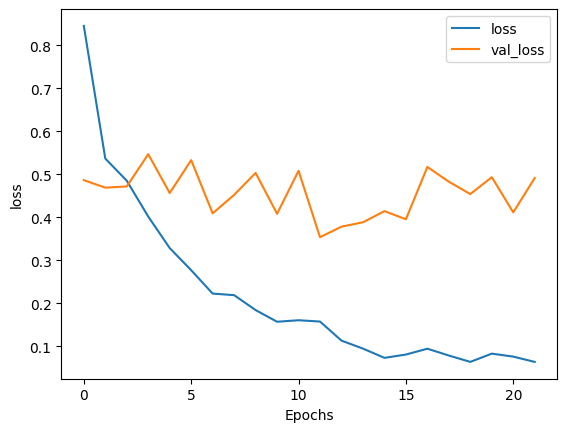

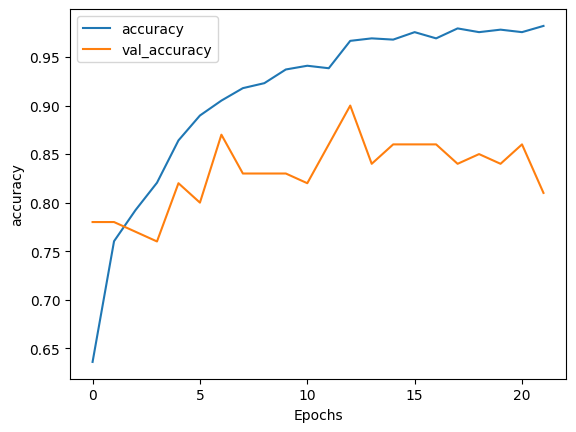

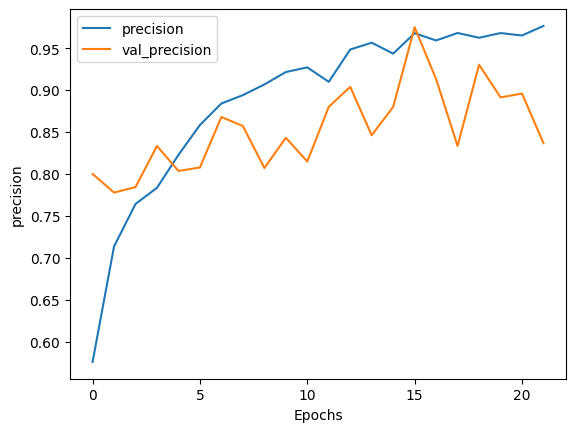

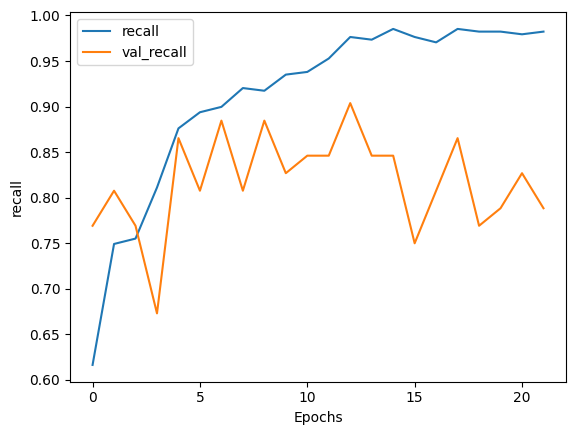

In [8]:
plotMetrics(VGG16_history, "loss")
plotMetrics(VGG16_history, "accuracy")
plotMetrics(VGG16_history, "precision")
plotMetrics(VGG16_history, "recall")

---
# Testing
---

In [22]:
%cd /content
loadedModel = tf.keras.models.load_model("VGG16-1-gen.keras")

/content


In [23]:
val_loss, val_accuracy, val_precision, val_recall = loadedModel.evaluate(testingSet)

print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.8711 - loss: 0.3363 - precision: 0.8316 - recall: 0.8990
Loss: 0.4521
Accuracy: 0.8352
Precision: 0.8182
Recall: 0.8372


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


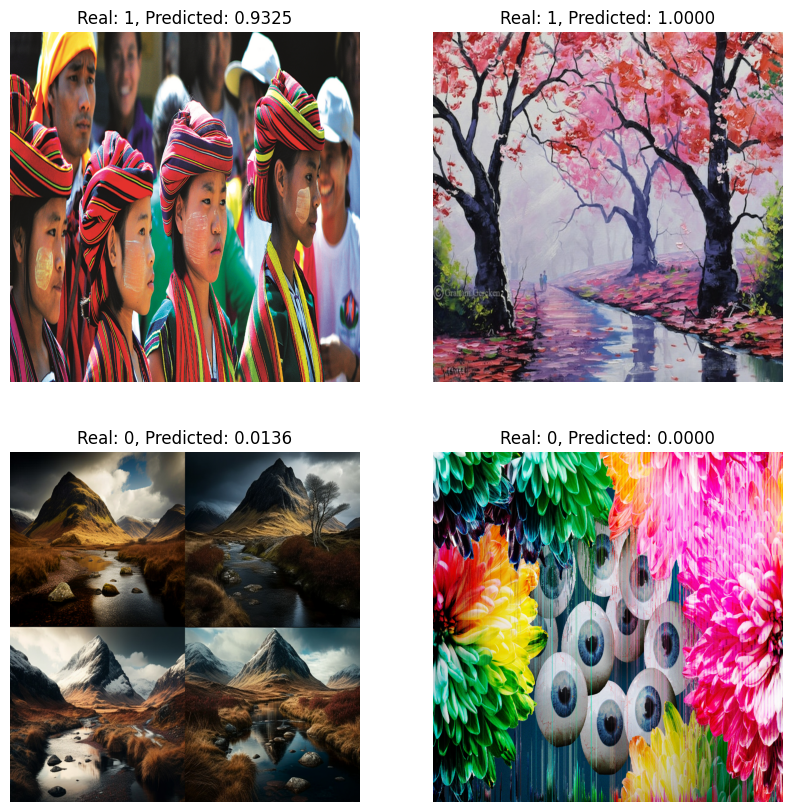

In [36]:
plt.figure(figsize=(10, 10))
for images, labels in trainingSet.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        result = loadedModel.predict(np.expand_dims(np.array(images[i]), axis = 0))
        plt.title(f"Real: {int(labels[i])}, Predicted: {result[0 ,0]:.4f}")
        plt.axis("off")

mkdir: cannot create directory ‘/content/imgTest’: File exists
/content/imgTest


Saving coffee-cup-splash-splatter-burst-brown-liquid-drips-abstract-illustration-dark-background-ai-generated_187882-4204.jpg to coffee-cup-splash-splatter-burst-brown-liquid-drips-abstract-illustration-dark-background-ai-generated_187882-4204 (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


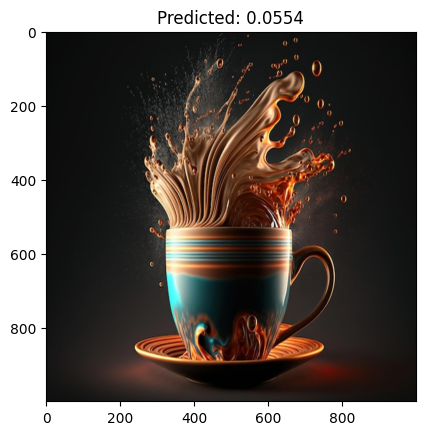

In [38]:
!mkdir /content/imgTest
%cd /content/imgTest
uploaded = files.upload()
uploadName = list(uploaded.keys())[0]

with pimg.open(uploadName) as img:
  res = img.resize(imgDim).convert('RGB')
  result = loadedModel.predict(np.expand_dims(np.array(res), axis = 0))
  plt.title(f"Predicted: {result[0 ,0]:.4f}")
  imgplot = plt.imshow(res)
  plt.show()